##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lite를 사용한 예술적 스타일 전이

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lite/examples/style_transfer/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lite/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lite/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lite/models/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

최근에 와서 딥 러닝에서 가장 흥미로운 발전 중 하나는 [예술적 스타일 전이](https://arxiv.org/abs/1508.06576) 또는 [파스티슈](https://en.wikipedia.org/wiki/Pastiche)라고 알려진 새로운 이미지를 만드는 기능인데, 이는 예술적 스타일을 표현하는 입력 이미지 하나와 그 내용을 나타내는 나머지 하나의 입력 이미지에 기반합니다.

![스타일 전송 예](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/formula.png)

이 기술을 사용하여 다양한 스타일의 아름다운 새 작품을 만들 수 있습니다.

![스타일 전송 예](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

TensorFlow Lite를 처음 사용하고 Android로 작업하는 경우, 다음 예제 애플리케이션을 탐색하면 시작하는 데 도움이 됩니다.

<a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/android">Android 예제</a> <a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/ios">iOS 예제</a>

Android 또는 iOS 이외의 플랫폼을 사용 중이거나 <a href="https://www.tensorflow.org/api_docs/python/tf/lite">TensorFlow Lite API에</a> 이미 익숙한 경우 이 튜토리얼을 따라 사전 훈련된 TensorFlow Lite 모델로 콘텐츠 및 스타일 이미지 쌍에 스타일 전이를 적용하는 방법을 배울 수 있습니다. 모델을 사용하여 자신의 모바일 애플리케이션에 스타일 전이를 추가할 수 있습니다.

모델은 [GitHub](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization#train-a-model-on-a-large-dataset-with-data-augmentation-to-run-on-mobile)에서 오픈 소스입니다. 다른 매개변수를 사용하여 모델을 다시 훈련할 수 있습니다(예: 출력 이미지가 콘텐츠 이미지처럼 보이도록 콘텐츠 레이어의 가중치를 높임).

## 모델 아키텍처 이해하기

![모델 아키텍처](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

해당 예술적 스타일 전이 모델은 두 개의 하위 모델로 구성됩니다.

1. **스타일 예측 모델**: 입력 스타일 이미지를 100차원 스타일 병목 벡터로 가져오는 MobilenetV2 기반 신경망
2. **스타일 변환 모델**: 콘텐츠 이미지에 스타일 병목 벡터를 적용하고 스타일화된 이미지를 만드는 신경망

앱에서 고정된 스타일 이미지 집합만 지원해야 하는 경우 해당 스타일 병목 벡터를 미리 계산하고 앱의 바이너리에서 스타일 예측 모델을 제외할 수 있습니다.

## 설정

종속성을 가져옵니다.

In [2]:
import tensorflow as tf
print(tf.__version__)

2022-12-14 20:34:17.209224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:34:17.209325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:34:17.209335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

콘텐츠 및 스타일 이미지와 사전 훈련된 TensorFlow Lite 모델을 다운로드합니다.

In [4]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

  8192/458481 [..............................] - ETA: 0s

458481/458481 [==============================] - 0s 0us/step


  8192/108525 [=>............................] - ETA: 0s

108525/108525 [==============================] - 0s 0us/step


   8192/2828838 [..............................] - ETA: 0s

2828838/2828838 [==============================] - 0s 0us/step


  8192/284398 [..............................] - ETA: 0s

284398/284398 [==============================] - 0s 0us/step


## 입력 전처리하기

- 콘텐츠 이미지와 스타일 이미지는 픽셀 값이 [0..1] 사이의 float32 숫자인 RGB 이미지여야 합니다.
- 스타일 이미지 크기는 (1, 256, 256, 3)이어야 합니다. 중앙에서 이미지를 자르고 크기를 조정합니다.
- 콘텐츠 이미지는 (1, 384, 384, 3)이어야 합니다. 중앙에서 이미지를 자르고 크기를 조정합니다.

In [5]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Style Image Shape:', preprocessed_style_image.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## 입력 시각화하기

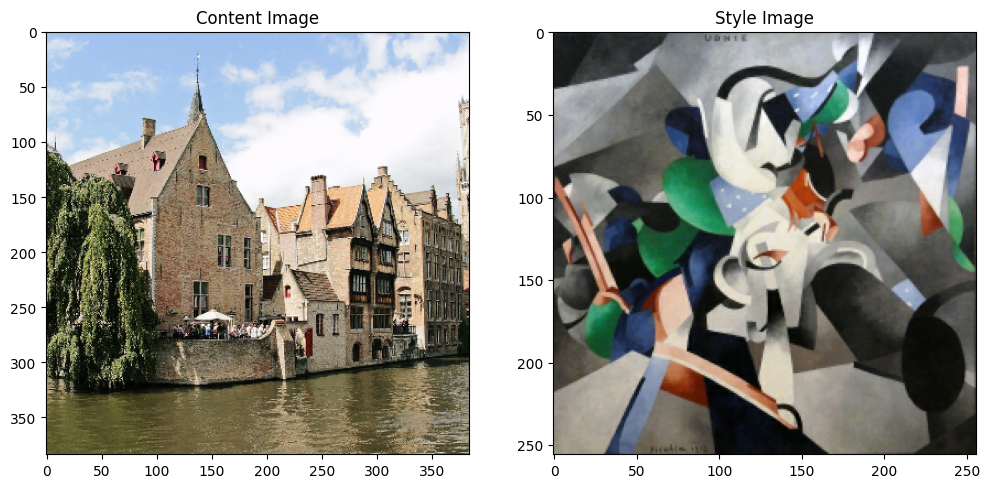

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

## TensorFlow Lite로 스타일 전이 실행하기

### 스타일 예측

In [7]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### 스타일 변환

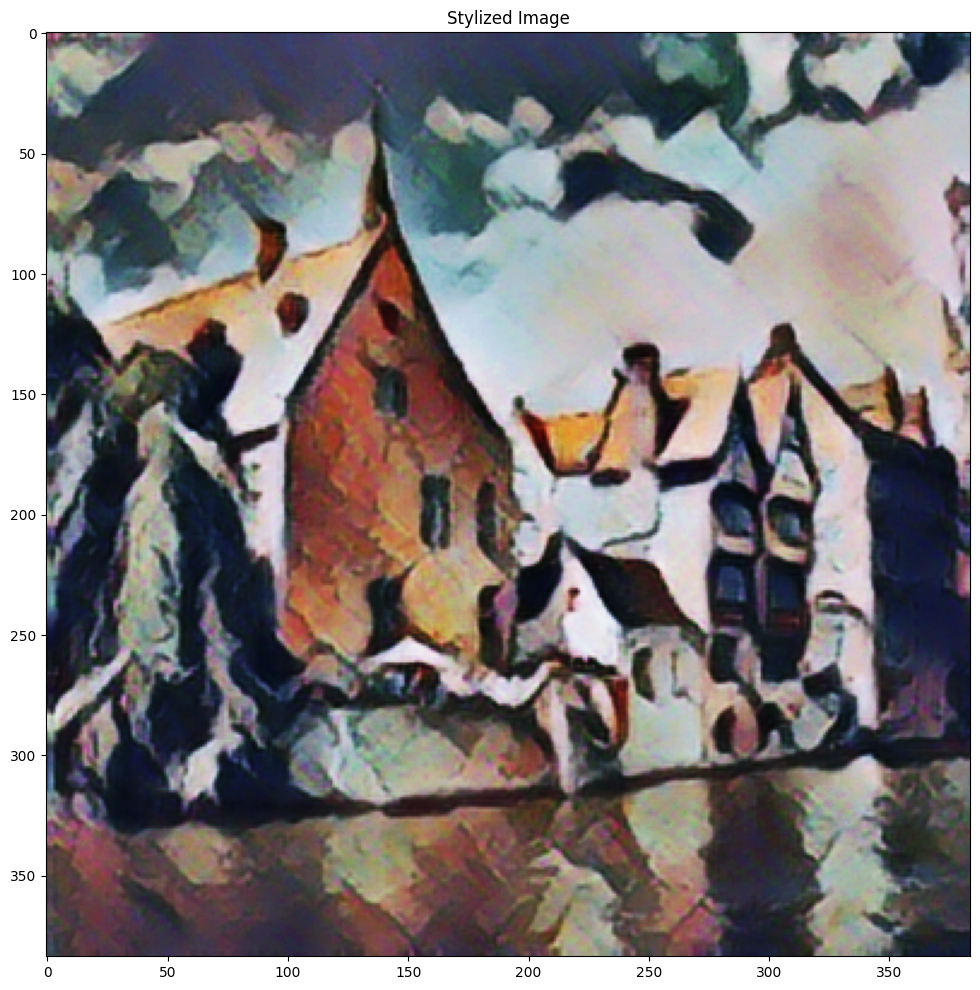

In [8]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### 스타일 블렌딩

콘텐츠 이미지의 스타일을 스타일화된 출력에 혼합하여 출력을 콘텐츠 이미지와 더 비슷하게 만들 수 있습니다.

In [9]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

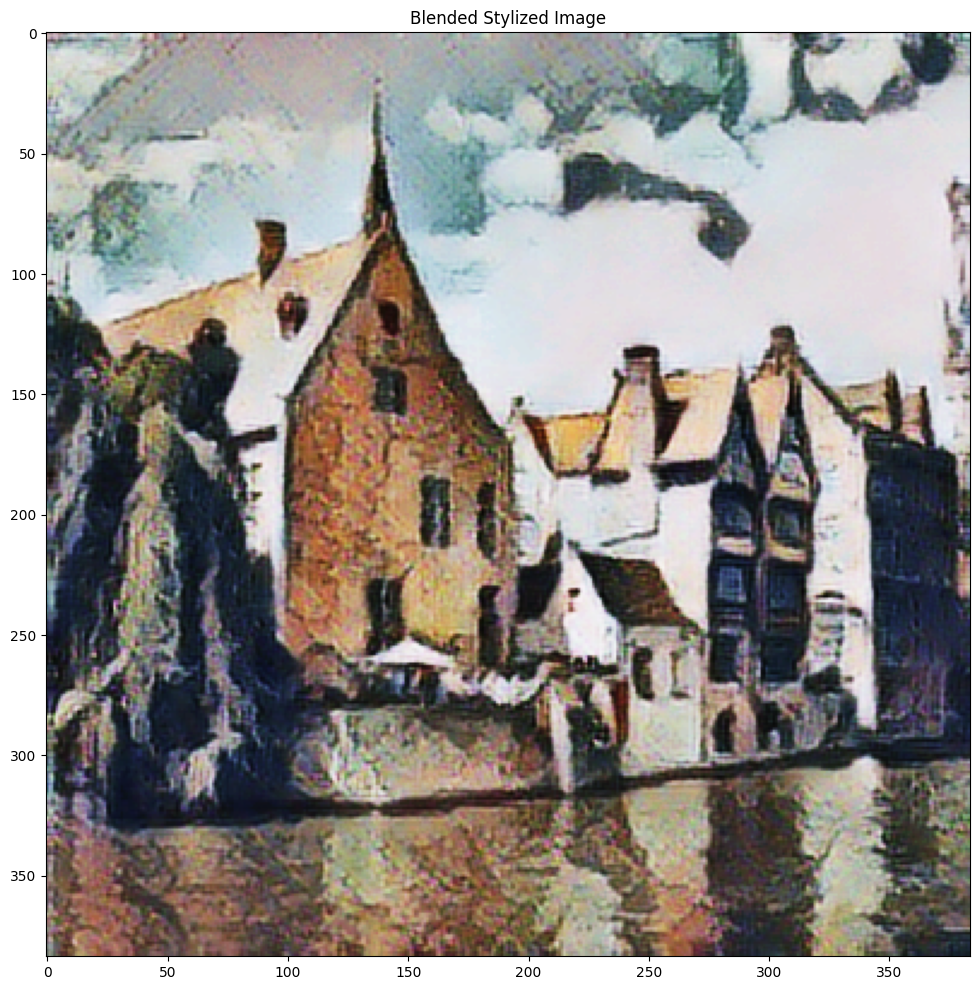

In [10]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

## 성능 벤치마크

성능 벤치마크 수치는 [여기에 설명된](https://www.tensorflow.org/lite/performance/benchmarks) 도구를 사용하여 생성됩니다.

<table>
<thead>
<tr>
<th>모델명</th> <th>모델 크기</th>  <th>기기</th> <th>NNAPI</th> <th>CPU</th> <th>GPU</th>
</tr> </thead>
<tr> <td rowspan="3"><a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite">스타일 예측 모델(int8)</a></td>
<td rowspan="3">2.8Mb</td>
<td>Pixel 3(Android 10)</td> <td>142ms</td>
<td>14ms *</td>
<td></td>
</tr>
<tr>
<td>Pixel 4(Android 10)</td> <td>5.2ms</td>
<td>6.7ms *</td>
<td></td>
</tr>
<tr>
<td>iPhone XS(iOS 12.4.1)</td> <td></td>
<td>10.7ms **</td>
<td></td>
</tr>
<tr> <td rowspan="3"><a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite">스타일 변환 모델(int8)</a></td>
<td rowspan="3">0.2Mb</td>
<td>Pixel 3(Android 10)</td> <td></td>
<td>540ms *</td>
<td></td>
</tr>
<tr>
<td>Pixel 4(Android 10)</td> <td></td>
<td>405ms *</td>
<td></td>
</tr>
<tr>
<td>iPhone XS(iOS 12.4.1)</td> <td></td>
<td>251ms **</td>
<td></td>
</tr>
<tr> <td rowspan="2"><a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/prediction/1?lite-format=tflite">스타일 예측 모델(float16)</a></td>
<td rowspan="2">4.7Mb</td>
<td>Pixel 3(Android 10)</td> <td>86ms</td>
<td>28ms *</td>
<td>9.1ms</td>
</tr>
<tr>
<td>Pixel 4(Android 10)</td>
<td>32ms</td>
<td>12ms *</td>
<td>10ms</td>
</tr>
<tr> <td rowspan="2"><a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/transfer/1?lite-format=tflite">스타일 전송 모델(float16)</a></td>
<td rowspan="2">0.4Mb</td>
<td>Pixel 3(Android 10)</td> <td>1095ms</td>
<td>545ms *</td>
<td>42ms</td>
</tr>
<tr>
<td>Pixel 4(Android 10)</td>
<td>603ms</td>
<td>377ms *</td>
<td>42ms</td>
</tr>
</table>

** 4개의 스레드가 사용되었습니다.*
*** 최상의 결과를 위해 iPhone에 2개의 스레드가 있습니다.*
